In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import warnings
from matplotlib.ticker import StrMethodFormatter, FuncFormatter
from scipy import stats

sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
sales = pd.read_csv('sales_test.csv')
cancelled = pd.read_csv('canceled_test.csv')
display(sales.head())
display(cancelled.head())

Order No Order Date  Line No  Ship To Address No  Item Code  Qty Ordered  \
0    528758  3 01 2017        1           1358538.0     111931         70.0   
1    528791  3 01 2017        1           1254798.0    1029071         10.0   
2    528791  3 01 2017        2           1254798.0    1033341         10.0   
3    528791  3 01 2017        3           1254798.0    1040827          5.0   
4    528791  3 01 2017        4           1254798.0   10106111         10.0   

   Qty Shipped  
0         70.0  
1         10.0  
2         10.0  
3          5.0  
4         10.0

Order No Order Date  Line No  Ship To Address No  Item Code  Qty Ordered  \
0    528703  3 01 2017        1           1857566.0   10135139            1   
1    528705  3 01 2017        1           1857566.0   10135140            1   
2    528706  3 01 2017        2           1857566.0   10135138            1   
3    528707  3 01 2017        1           1857566.0   10135132            1   
4    528708  3 01 2017        1           1857566.0   10135359            1   

   Qty Cancelled  
0              1  
1              1  
2              1  
3              1  
4              1

In [3]:
sales.isnull().sum()

Order No              0
Order Date            0
Line No               0
Ship To Address No    0
Item Code             0
Qty Ordered           0
Qty Shipped           0
dtype: int64

In [4]:
cancelled.isnull().sum()

Order No              0
Order Date            0
Line No               0
Ship To Address No    0
Item Code             0
Qty Ordered           0
Qty Cancelled         0
dtype: int64

In [5]:
sales.rename(columns={'Ship To Address No': 'Client', 'Item Code': 'SKU'}, inplace=True)
cancelled.rename(columns={'Ship To Address No': 'Client', 'Item Code': 'SKU'}, inplace=True)

In [6]:
sales['Order Date'] = pd.to_datetime(sales['Order Date'], dayfirst=True)
cancelled['Order Date'] = pd.to_datetime(cancelled['Order Date'], dayfirst=True)

In [7]:
sales[['Client', 'Qty Ordered', 'Qty Shipped']] = sales[['Client', 'Qty Ordered', 'Qty Shipped']].astype('int64')
cancelled[['Client', 'Qty Ordered', 'Qty Cancelled']] = cancelled[['Client', 'Qty Ordered', 'Qty Cancelled']].astype('int64')

In [8]:
cat_cols = ['Order No', 'Line No', 'Client', 'SKU']
num_cols = ['Qty Ordered', 'Qty Cancelled', 'Qty Shipped']
sales[cat_cols] = sales[cat_cols].astype(str)
cancelled[cat_cols] = cancelled[cat_cols].astype(str)

In [9]:
display(sales.head())
display(cancelled.head())

Order No Order Date Line No   Client       SKU  Qty Ordered  Qty Shipped
0   528758 2017-01-03       1  1358538    111931           70           70
1   528791 2017-01-03       1  1254798   1029071           10           10
2   528791 2017-01-03       2  1254798   1033341           10           10
3   528791 2017-01-03       3  1254798   1040827            5            5
4   528791 2017-01-03       4  1254798  10106111           10           10

Order No Order Date Line No   Client       SKU  Qty Ordered  Qty Cancelled
0   528703 2017-01-03       1  1857566  10135139            1              1
1   528705 2017-01-03       1  1857566  10135140            1              1
2   528706 2017-01-03       2  1857566  10135138            1              1
3   528707 2017-01-03       1  1857566  10135132            1              1
4   528708 2017-01-03       1  1857566  10135359            1              1

In [10]:
merged_df = pd.merge(sales, cancelled, how='outer', on=cat_cols+['Order Date'], 
                     suffixes=('', '_cancelled'))
merged_df['Qty Ordered'] = merged_df[['Qty Ordered', 'Qty Ordered_cancelled']].max(axis=1)

merged_df.drop(columns=['Qty Ordered_cancelled'], inplace=True)
merged_df['Qty Shipped'] = merged_df['Qty Shipped'].fillna(0)
merged_df['Qty Cancelled'] = merged_df['Qty Cancelled'].fillna(0)
merged_df[num_cols] = merged_df[num_cols].astype('int64')

merged_df.head()

Order No Order Date Line No   Client       SKU  Qty Ordered  Qty Shipped  \
0   528703 2017-01-03       1  1857566  10135139            1            0   
1   528705 2017-01-03       1  1857566  10135140            1            0   
2   528706 2017-01-03       2  1857566  10135138            1            0   
3   528707 2017-01-03       1  1857566  10135132            1            0   
4   528708 2017-01-03       1  1857566  10135359            1            0   

   Qty Cancelled  
0              1  
1              1  
2              1  
3              1  
4              1

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31977 entries, 0 to 31976
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order No       31977 non-null  object        
 1   Order Date     31977 non-null  datetime64[ns]
 2   Line No        31977 non-null  object        
 3   Client         31977 non-null  object        
 4   SKU            31977 non-null  object        
 5   Qty Ordered    31977 non-null  int64         
 6   Qty Shipped    31977 non-null  int64         
 7   Qty Cancelled  31977 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 2.0+ MB


In [12]:
merged_df[num_cols].describe()

Qty Ordered  Qty Cancelled   Qty Shipped
count  31977.000000   31977.000000  31977.000000
mean       6.728211       0.997999      5.730212
std       44.791064      29.203275     34.129841
min        1.000000       0.000000      0.000000
25%        1.000000       0.000000      1.000000
50%        1.000000       0.000000      1.000000
75%        3.000000       0.000000      2.000000
max     4500.000000    4500.000000   2000.000000

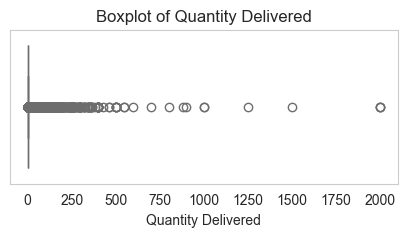

In [13]:
plt.figure(figsize=(5, 2))
sns.boxplot( x='Qty Shipped', data=merged_df, color='salmon')
plt.title('Boxplot of Quantity Delivered')
plt.xlabel('Quantity Delivered')
plt.savefig('boxplot_all.png', bbox_inches='tight')
plt.show()

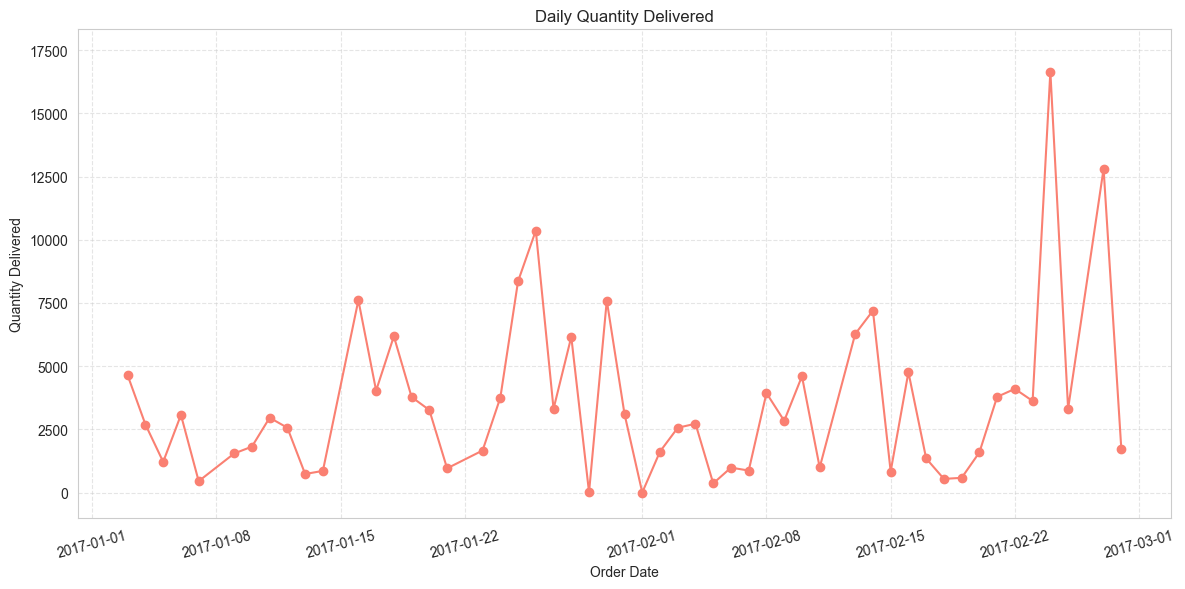

In [14]:
daily_volume = merged_df.groupby('Order Date')['Qty Shipped'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_volume['Order Date'], daily_volume['Qty Shipped'], marker='o', linestyle='-', color='salmon')
plt.title('Daily Quantity Delivered')
plt.xlabel('Order Date')
plt.ylabel('Quantity Delivered')
plt.xticks(rotation=15)
plt.grid(linestyle='--', alpha=0.5)
plt.ylim(-1000, max(daily_volume['Qty Shipped'])*1.1)
plt.tight_layout()
plt.savefig('daily_agg.png', bbox_inches='tight')
plt.show()

In [15]:
def abc_classification(df, value_column):
    df_sorted = df.sort_values(by=value_column, ascending=False)
    df_sorted['Cum Sum'] = df_sorted[value_column].cumsum()
    df_sorted.reset_index(drop=True, inplace=True)
    df_sorted['Cum Perc'] = 100 * df_sorted['Cum Sum'] / df_sorted[value_column].sum()
    df_sorted['Class'] = pd.cut(df_sorted['Cum Perc'], bins=[0, 80, 95, 100], labels=['A', 'B', 'C'])
    return df_sorted

In [16]:
# Applying ABC classification to SKUs
sku_volume = merged_df.groupby('SKU')['Qty Shipped'].sum().reset_index()
abc_skus = abc_classification(sku_volume, 'Qty Shipped')

In [17]:
# Applying ABC classification to Clients
client_volume = merged_df.groupby('Client')['Qty Shipped'].sum().reset_index()
abc_clients = abc_classification(client_volume, 'Qty Shipped')

In [18]:
abc_skus.to_csv('abc_skus.csv', index=False)
abc_skus

SKU  Qty Shipped  Cum Sum    Cum Perc Class
0   10098739        27173    27173   14.829590     A
1     111931        15575    42748   23.329604     A
2    1041106        13178    55926   30.521462     A
3    1040765        11980    67906   37.059514     A
4     110441         9600    77506   42.298687     A
..       ...          ...      ...         ...   ...
74  10102551            0   183235  100.000000     C
75  10102559            0   183235  100.000000     C
76  10102557            0   183235  100.000000     C
77  10102556            0   183235  100.000000     C
78   1039721            0   183235  100.000000     C

[79 rows x 5 columns]

In [19]:
abc_clients.to_csv('abc_clients.csv', index=False)
abc_clients

Client  Qty Shipped  Cum Sum    Cum Perc Class
0    1795849        14599    14599    7.967364     A
1    1255123        11629    26228   14.313859     A
2    1255548        11567    37795   20.626518     A
3    1740542        10697    48492   26.464376     A
4    1254798         9584    58076   31.694818     A
..       ...          ...      ...         ...   ...
726  1645437            0   183235  100.000000     C
727  1496687            0   183235  100.000000     C
728  1464929            0   183235  100.000000     C
729  1404699            0   183235  100.000000     C
730    62998            0   183235  100.000000     C

[731 rows x 5 columns]

In [20]:
for cl in ['A', 'B', 'C']:
    cl_skus_num = abc_skus[abc_skus['Class'] == cl].count()['SKU']
    print(f'Number of SKUs in Class {cl}: {cl_skus_num}')

Number of SKUs in Class A: 21
Number of SKUs in Class B: 16
Number of SKUs in Class C: 42


In [21]:
for cl in ['A', 'B', 'C']:
    cl_clients_num = abc_clients[abc_clients['Class'] == cl].count()['Client']
    print(f'Number of Clients in Class {cl}: {cl_clients_num}')

Number of Clients in Class A: 56
Number of Clients in Class B: 267
Number of Clients in Class C: 408


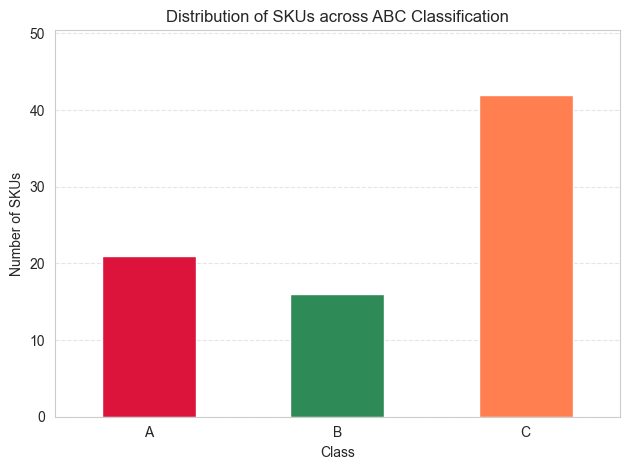

In [22]:
colours = ['crimson', 'seagreen', 'coral']
abc_skus_count = abc_skus['Class'].value_counts()[['A', 'B', 'C']]
abc_skus_count.plot(kind='bar', color=colours)
plt.title('Distribution of SKUs across ABC Classification')
plt.xlabel('Class')
plt.ylabel('Number of SKUs')
plt.xticks(rotation=0)
plt.ylim(0, max(abc_skus_count)*1.2)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('skus_by_class.png', bbox_inches='tight')
plt.show()

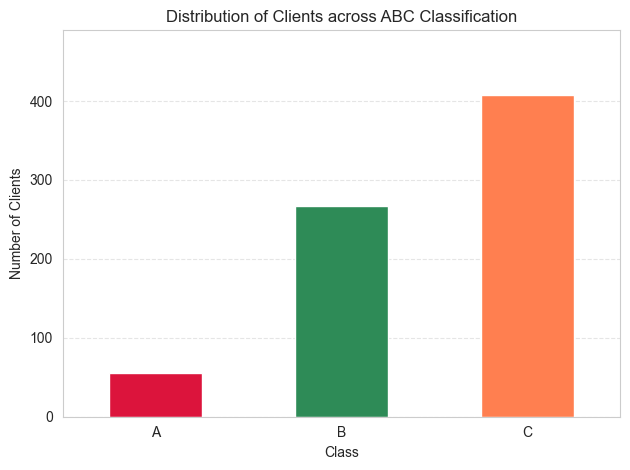

In [23]:
abc_clients_count = abc_clients['Class'].value_counts()[['A', 'B', 'C']]
abc_clients_count.plot(kind='bar', color=colours)
plt.title('Distribution of Clients across ABC Classification')
plt.xlabel('Class')
plt.ylabel('Number of Clients')
plt.xticks(rotation=0)
plt.ylim(0, max(abc_clients_count)*1.2)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('clients_by_class.png', bbox_inches='tight')
plt.show()

In [24]:
merged_df = pd.merge(merged_df, abc_skus[['SKU', 'Class']], how='left', on='SKU')
merged_df.rename(columns={'Class': 'SKU Class'}, inplace=True)
merged_df = pd.merge(merged_df, abc_clients[['Client', 'Class']], how='left', on='Client')
merged_df.rename(columns={'Class': 'Client Class'}, inplace=True)
merged_df.head()

Order No Order Date Line No   Client       SKU  Qty Ordered  Qty Shipped  \
0   528703 2017-01-03       1  1857566  10135139            1            0   
1   528705 2017-01-03       1  1857566  10135140            1            0   
2   528706 2017-01-03       2  1857566  10135138            1            0   
3   528707 2017-01-03       1  1857566  10135132            1            0   
4   528708 2017-01-03       1  1857566  10135359            1            0   

   Qty Cancelled SKU Class Client Class  
0              1         B            C  
1              1         B            C  
2              1         B            C  
3              1         B            C  
4              1         A            C

In [25]:
sku_class = merged_df.groupby(['Order Date', 'SKU Class'])['Qty Shipped'].sum().reset_index()
client_class = merged_df.groupby(['Order Date', 'Client Class'])['Qty Shipped'].sum().reset_index()

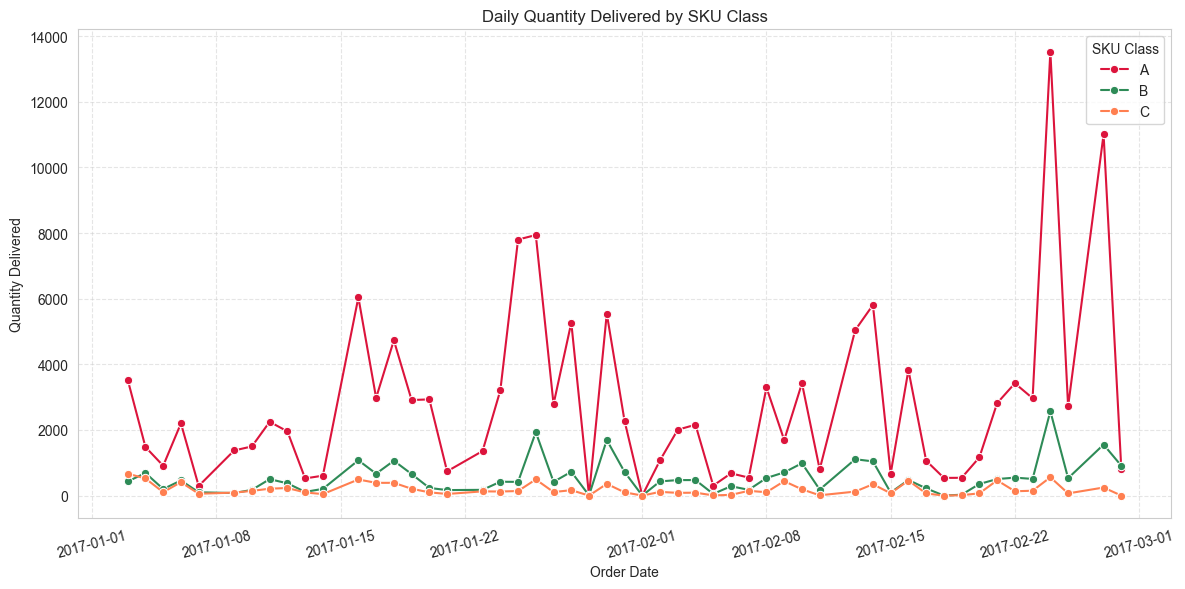

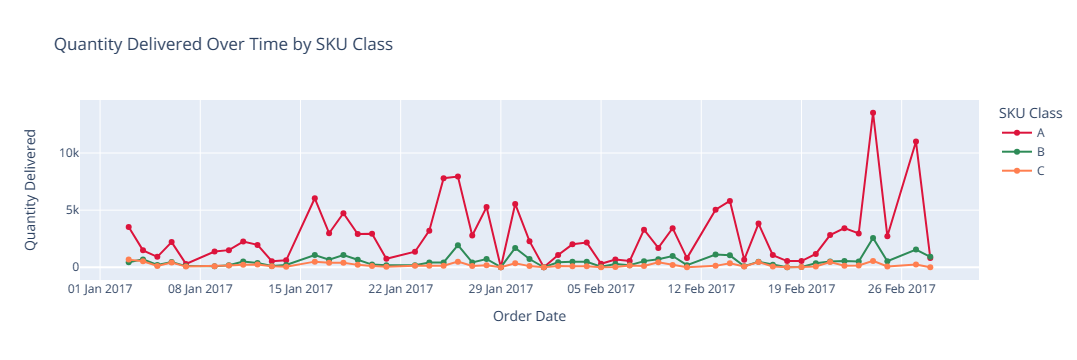

In [26]:
palette = {'A': 'crimson', 'B': 'seagreen', 'C': 'coral'}

plt.figure(figsize=(12, 6))
sns.lineplot(data=sku_class, x='Order Date', y='Qty Shipped', hue='SKU Class', palette=palette, marker='o')
plt.title('Daily Quantity Delivered by SKU Class')
plt.xlabel('Order Date')
plt.ylabel('Quantity Delivered')
plt.legend(title='SKU Class', loc='best')
plt.xticks(rotation=15)
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('sku_class_ts.png', bbox_inches='tight')
plt.show()


fig = px.line(sku_class, x='Order Date', y='Qty Shipped', color='SKU Class',
              title='Quantity Delivered Over Time by SKU Class', markers=True, 
              color_discrete_map=palette)
fig.update_layout(xaxis_title='Order Date', yaxis_title='Quantity Delivered', legend_title='SKU Class')
fig.update_xaxes(tickformat='%d %b %Y')
fig.show()

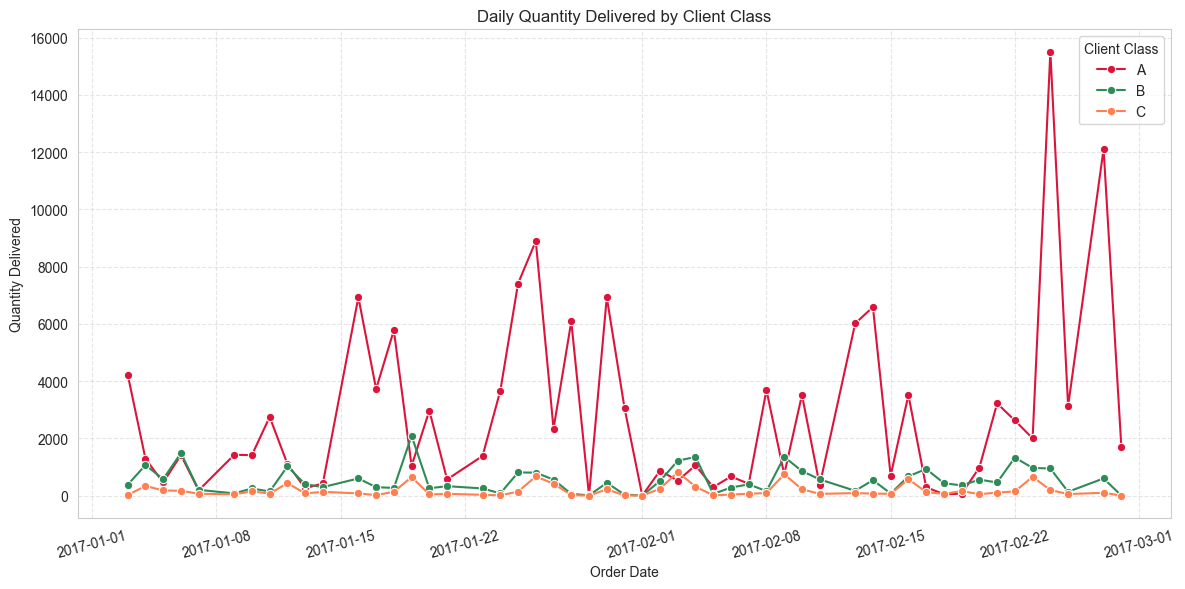

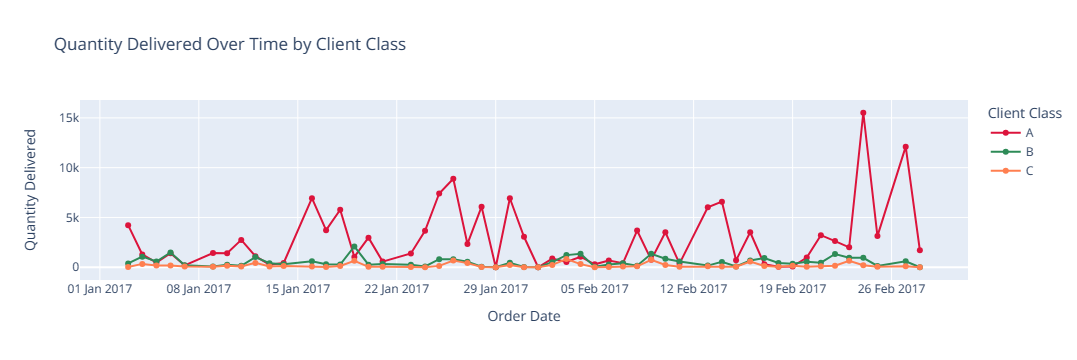

In [27]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=client_class, x='Order Date', y='Qty Shipped', hue='Client Class', palette=palette, marker='o')
plt.title('Daily Quantity Delivered by Client Class')
plt.xlabel('Order Date')
plt.ylabel('Quantity Delivered')
plt.legend(title='Client Class', loc='best')
plt.xticks(rotation=15)
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('client_class_ts.png', bbox_inches='tight')
plt.show()


fig = px.line(client_class, x='Order Date', y='Qty Shipped', color='Client Class',
              title='Quantity Delivered Over Time by Client Class', markers=True, 
              color_discrete_map=palette)
fig.update_layout(xaxis_title='Order Date', yaxis_title='Quantity Delivered', legend_title='Client Class')
fig.update_xaxes(tickformat='%d %b %Y')
fig.show()

In [28]:
def compute_service_level(df, group_by_column):
    service_level = df.groupby(group_by_column).agg({'Qty Ordered': 'sum', 'Qty Shipped': 'sum'}).reset_index()
    service_level['Service Level'] = service_level['Qty Shipped'] / service_level['Qty Ordered']
    service_level['Service Level'].replace([float('inf'), float('-inf'), np.nan], 0, inplace=True)
    service_level['Service Le']
    return service_level

In [29]:
service_level_sku = compute_service_level(merged_df, ['SKU'])
service_level_order = compute_service_level(merged_df, 'Order No')
service_level_client = compute_service_level(merged_df, ['Client'])
service_level_clientclass = compute_service_level(merged_df, 'Client Class')
service_level_skuclass = compute_service_level(merged_df, 'SKU Class')
service_level_date = compute_service_level(merged_df, 'Order Date')
service_level_date_clcl = compute_service_level(merged_df, ['Order Date', 'Client Class'])
service_level_date_skucl = compute_service_level(merged_df, ['Order Date', 'SKU Class'])

In [30]:
service_level_sku.to_csv('service_level_sku.csv', index=False)
display(service_level_sku.head())

service_level_client.to_csv('service_level_client.csv', index=False)
display(service_level_client.head())

service_level_order.to_csv('service_level_order.csv', index=False)
display(service_level_order.head())

service_level_clientclass.to_csv('service_level_clientclass.csv', index=False)
display(service_level_clientclass.head())

service_level_skuclass.to_csv('service_level_skuclass.csv', index=False)
display(service_level_skuclass.head())

service_level_date.to_csv('service_level_date.csv', index=False)
service_level_date_clcl.to_csv('service_level_date_clcl.csv', index=False)
service_level_date_skucl.to_csv('service_level_date_skucl.csv', index=False)

SKU  Qty Ordered  Qty Shipped  Service Level
0  10098739        29031        27173       0.935999
1  10102551           20            0       0.000000
2  10102556            2            0       0.000000
3  10102557           28            0       0.000000
4  10102559           28            0       0.000000

Client  Qty Ordered  Qty Shipped  Service Level
0  1254612         1464         1407       0.961066
1  1254686         1510         1510       1.000000
2  1254687          399          356       0.892231
3  1254688          413          358       0.866828
4  1254689          211          206       0.976303

Order No  Qty Ordered  Qty Shipped  Service Level
0   528703            1            0            0.0
1   528705            1            0            0.0
2   528706            1            0            0.0
3   528707            1            0            0.0
4   528708            1            0            0.0

Client Class  Qty Ordered  Qty Shipped  Service Level
0            A       172460       146369       0.848713
1            B        30545        27682       0.906269
2            C        12143         9184       0.756321

SKU Class  Qty Ordered  Qty Shipped  Service Level
0         A       165121       145019       0.878259
1         B        35244        28444       0.807059
2         C        14783         9772       0.661030

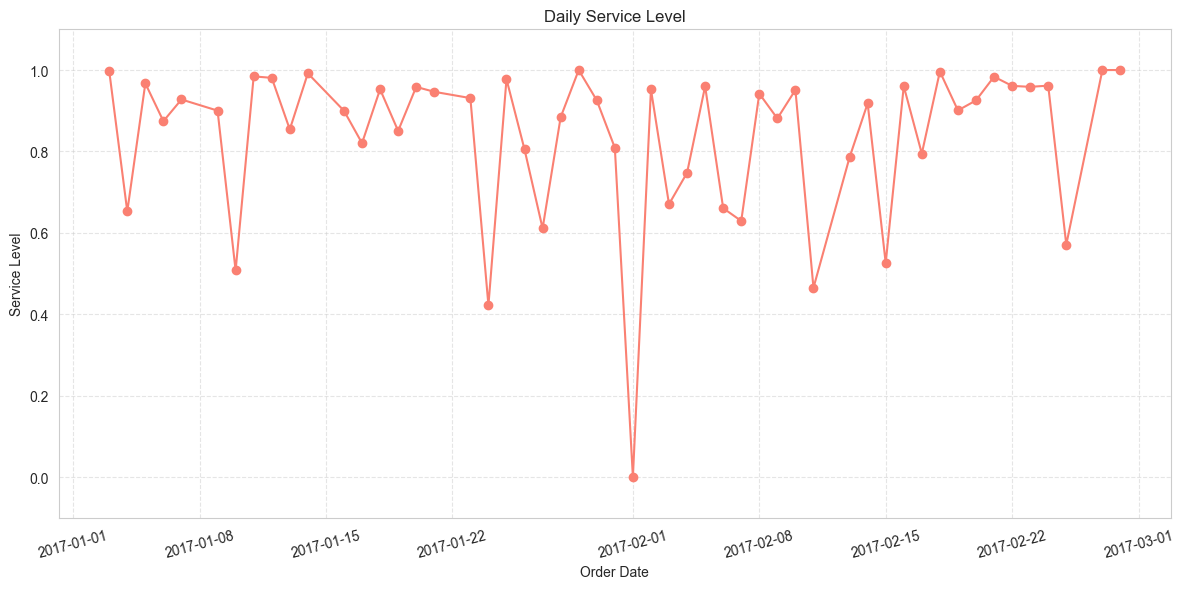

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(service_level_date['Order Date'], service_level_date['Service Level'], marker='o', linestyle='-', color='salmon')
plt.title('Daily Service Level')
plt.xlabel('Order Date')
plt.ylabel('Service Level')
plt.xticks(rotation=15)
plt.grid(linestyle='--', alpha=0.5)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.savefig('daily_sl.png', bbox_inches='tight')
plt.show()

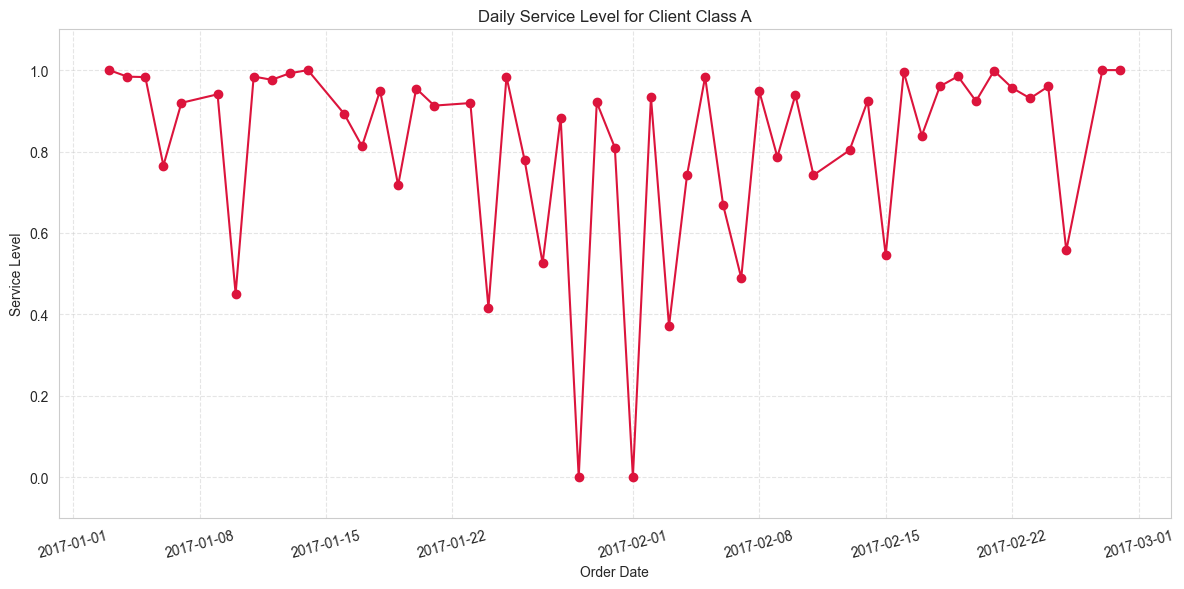

In [32]:
service_level_date_clA=service_level_date_clcl[service_level_date_clcl['Client Class'] == 'A']

plt.figure(figsize=(12, 6))
plt.plot(service_level_date_clA['Order Date'], service_level_date_clA['Service Level'], marker='o', linestyle='-', color='crimson')
plt.title('Daily Service Level for Client Class A')
plt.xlabel('Order Date')
plt.ylabel('Service Level')
plt.xticks(rotation=15)
plt.grid(linestyle='--', alpha=0.5)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.savefig('daily_sl_clA.png', bbox_inches='tight')
plt.show()

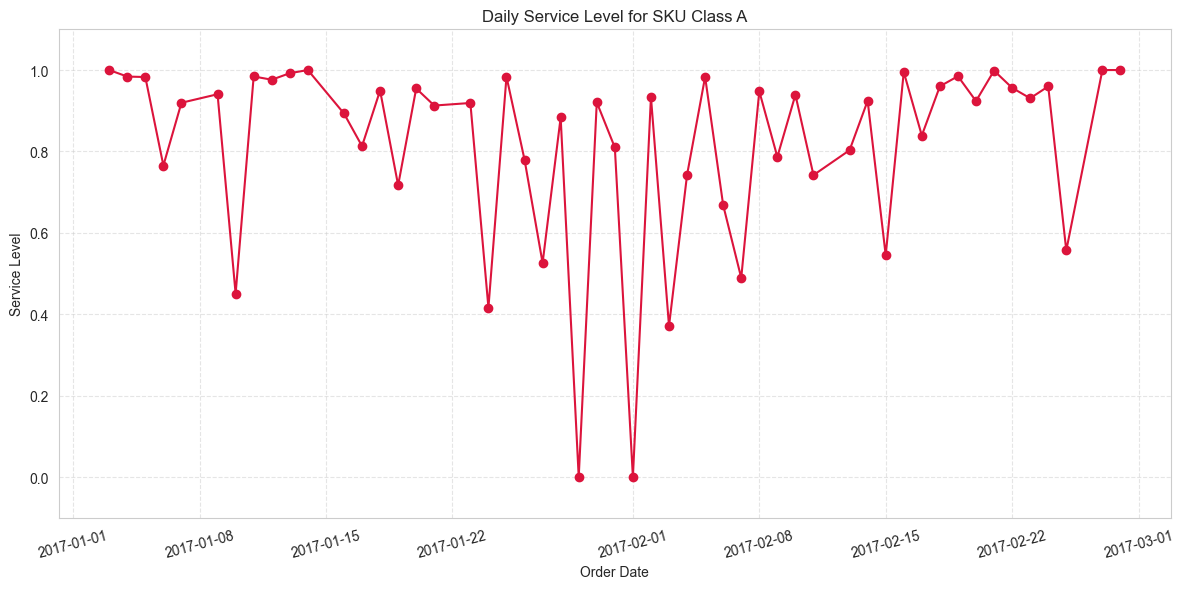

In [33]:
service_level_date_skuA=service_level_date_skucl[service_level_date_skucl['SKU Class'] == 'A']

plt.figure(figsize=(12, 6))
plt.plot(service_level_date_clA['Order Date'], service_level_date_clA['Service Level'], marker='o', linestyle='-', color='crimson')
plt.title('Daily Service Level for SKU Class A')
plt.xlabel('Order Date')
plt.ylabel('Service Level')
plt.xticks(rotation=15)
plt.grid(linestyle='--', alpha=0.5)
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.savefig('daily_sl_skuA.png', bbox_inches='tight')
plt.show()

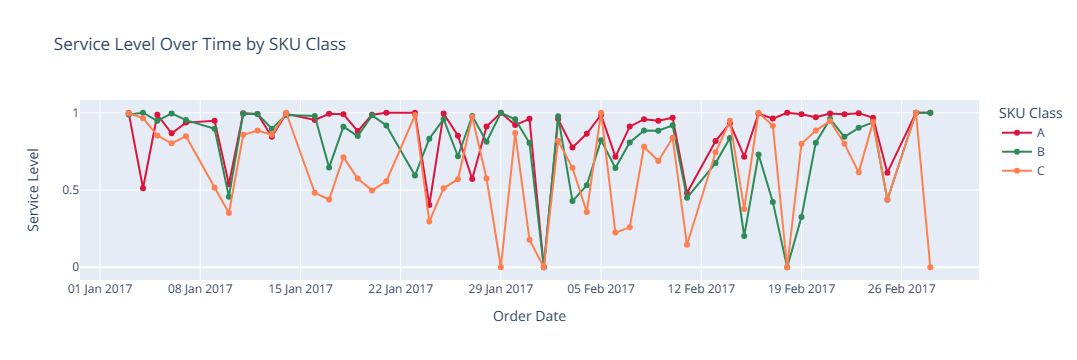

In [34]:
fig = px.line(service_level_date_skucl, x='Order Date', y='Service Level', 
              color='SKU Class', title='Service Level Over Time by SKU Class', 
              markers=True, color_discrete_map=palette)
fig.update_layout(xaxis_title='Order Date', yaxis_title='Service Level', legend_title='SKU Class')
fig.update_xaxes(tickformat='%d %b %Y')
fig.show()

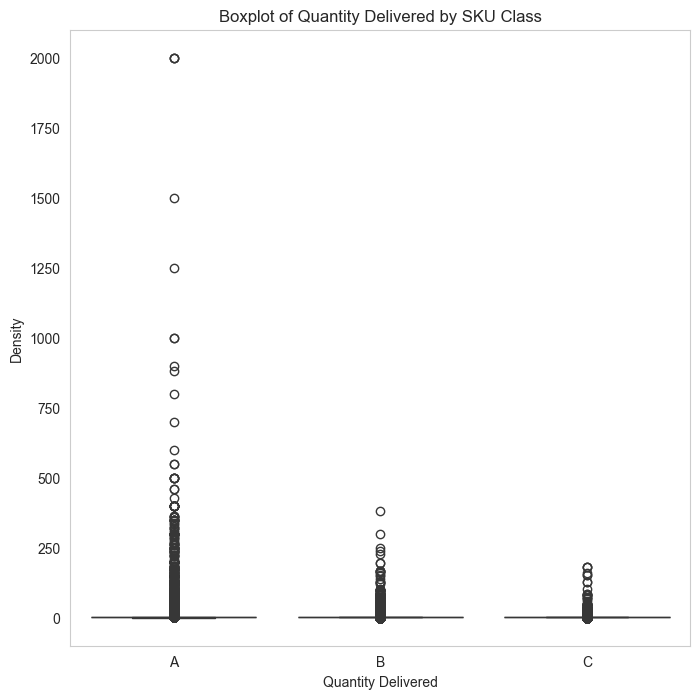

In [35]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=merged_df, y='Qty Shipped', x='SKU Class', palette=palette)
plt.title('Boxplot of Quantity Delivered by SKU Class')
plt.xlabel('Quantity Delivered')
plt.ylabel('Density')
plt.savefig('boxplot_skuclass.png', bbox_inches='tight')
plt.show()

In [36]:
service_level_client_class = compute_service_level(merged_df, ['Client', 'Client Class'])
service_level_client_class = service_level_client_class[service_level_client_class['Qty Ordered'] > 0]
service_level_sku_class = compute_service_level(merged_df, ['SKU', 'SKU Class'])
service_level_sku_class = service_level_sku_class[service_level_sku_class['Qty Ordered'] > 0]

In [37]:
class_a_skus = service_level_sku_class[service_level_sku_class['SKU Class'] == 'A']
top_5_high_skus = class_a_skus.sort_values(by='Service Level', ascending=False).head(5)
top_5_low_skus = class_a_skus.sort_values(by='Service Level', ascending=True).head(5)

class_a_clients = service_level_client_class[service_level_client_class['Client Class'] == 'A']
top_5_high_clients = class_a_clients.sort_values(by='Service Level', ascending=False).head(5)
top_5_low_clients = class_a_clients.sort_values(by='Service Level', ascending=True).head(5)

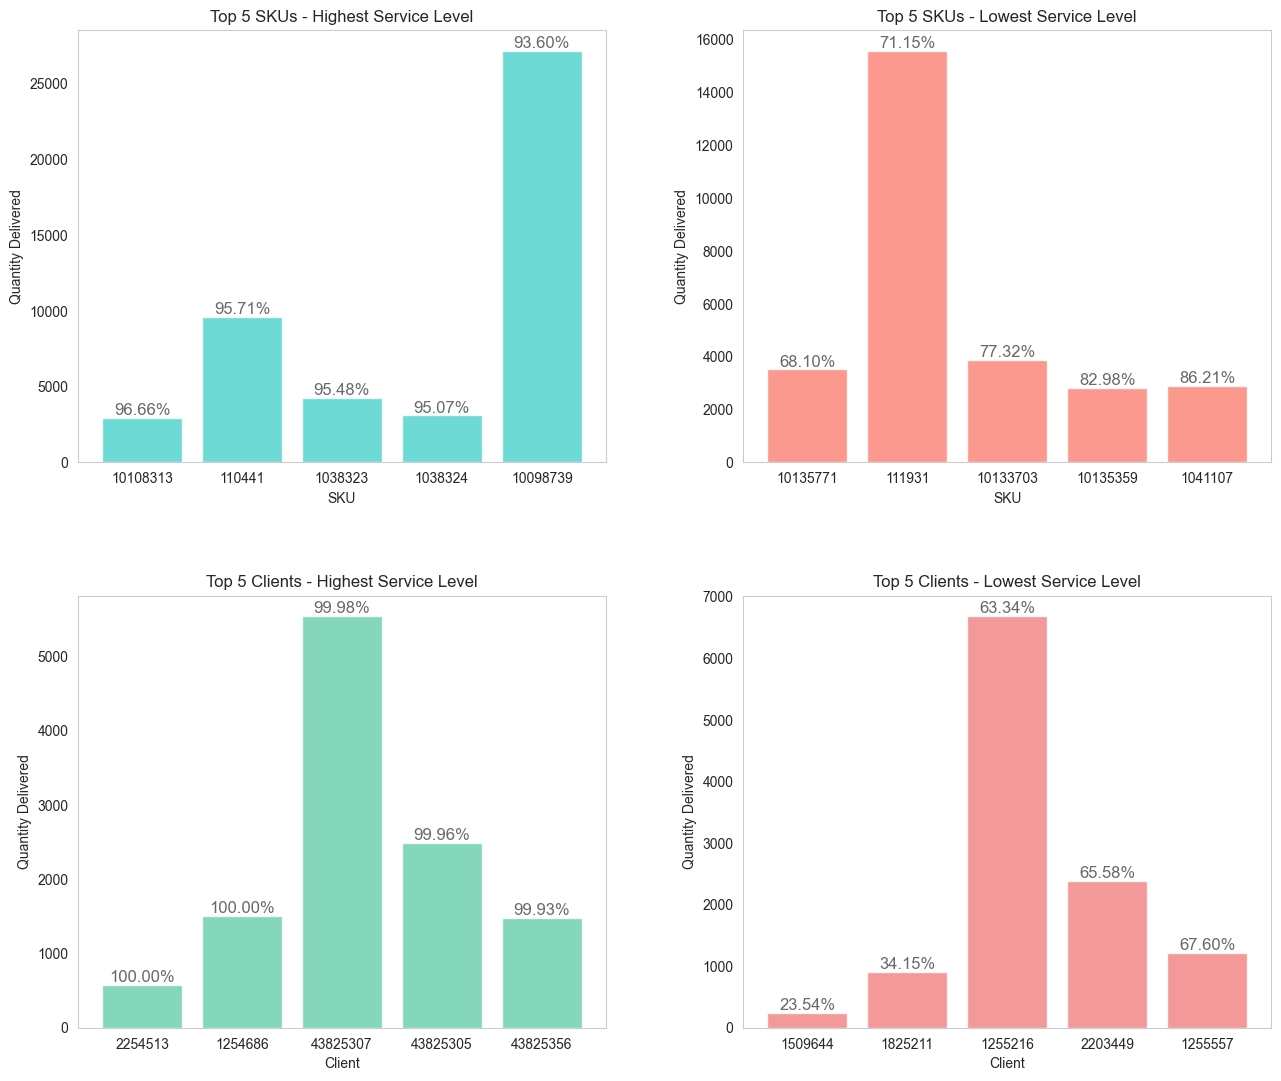

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()


datasets = [top_5_high_skus, top_5_low_skus, top_5_high_clients, top_5_low_clients]
colours = ['mediumturquoise', 'salmon', 'mediumaquamarine', 'lightcoral']
titles = ['Top 5 SKUs - Highest Service Level', 'Top 5 SKUs - Lowest Service Level',
          'Top 5 Clients - Highest Service Level', 'Top 5 Clients - Lowest Service Level']

for ax, data, colour, title in zip(axs, datasets, colours, titles):
    bars = ax.bar(data['SKU'] if 'SKU' in data else data['Client'], data['Qty Shipped'], color=colour, label='Quantity Delivered', alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('SKU' if 'SKU' in data else 'Client')
    ax.set_ylabel('Quantity Delivered')
    ax.tick_params(axis='x', labelrotation=0)
    
    # Annotate Service Level on each bar
    for bar, sl in zip(bars, data['Service Level']):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{sl:.2%}', 
                ha='center', va='bottom', fontsize=12, color='dimgrey')

plt.tight_layout(pad=5)
plt.savefig('top5_annotated.png', bbox_inches='tight')
plt.show()

In [39]:
service_level_client_class.describe()

Qty Ordered   Qty Shipped  Service Level
count    731.000000    731.000000     731.000000
mean     294.320109    250.663475       0.872689
std     1390.427995   1164.860385       0.189362
min        1.000000      0.000000       0.000000
25%       21.000000     18.500000       0.858696
50%       51.000000     45.000000       0.922112
75%      102.000000     92.000000       0.970149
max    20907.000000  14599.000000       1.000000

In [40]:
service_level_sku_class.describe()

Qty Ordered   Qty Shipped  Service Level
count     79.000000     79.000000      79.000000
mean    2723.392405   2319.430380       0.674762
std     4747.872267   4179.698863       0.356499
min        1.000000      0.000000       0.000000
25%      261.500000     95.500000       0.509660
50%      908.000000    755.000000       0.831120
75%     3281.500000   2859.500000       0.925735
max    29031.000000  27173.000000       1.000000